In [1]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader

In [2]:
loader = DirectoryLoader('data', glob="**/*.txt")
docs = loader.load()

In [3]:
docs

[Document(page_content="Introduction: Welcome to Bella Vista, where every dish is a love letter to the vibrant flavors, fresh ingredients, and time-honored traditions of Italian cuisine. At the heart of our culinary philosophy lies a deep reverence for the simple yet sublime beauty of the Mediterranean diet, which celebrates the natural bounty of the land and sea, and the art of transforming humble ingredients into extraordinary culinary creations. Join us as we embark on a gastronomic journey through the diverse regions of Italy, from the sun-drenched shores of Sicily to the verdant hills of Tuscany, to discover the soul-stirring flavors that have captivated palates for centuries.\n\nChapter 1: The Essence of Italian Cuisine Italian cuisine is a celebration of simplicity, freshness, and flavor, where every dish is a reflection of the land, the culture, and the people who create it. At Bella Vista, we embrace this philosophy wholeheartedly, sourcing the finest seasonal ingredients from

In [4]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [5]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=20,
    length_function=len,
    is_separator_regex=False,
)

In [6]:
docs = text_splitter.split_documents(docs)

In [7]:
docs[0]

Document(page_content='Introduction: Welcome to Bella Vista, where every dish is a love letter to the vibrant flavors, fresh ingredients, and time-honored traditions of Italian cuisine. At the heart of our culinary', metadata={'source': 'data/data3.txt'})

In [8]:
texts = [doc.page_content for doc in docs]

In [9]:
texts[0]

'Introduction: Welcome to Bella Vista, where every dish is a love letter to the vibrant flavors, fresh ingredients, and time-honored traditions of Italian cuisine. At the heart of our culinary'

In [10]:
import tiktoken

def num_tokens_from_string(string: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(string))
    return num_tokens

In [11]:
counts = [num_tokens_from_string(t) for t in texts]

In [12]:
len(counts)

152

<function matplotlib.pyplot.show(close=None, block=None)>

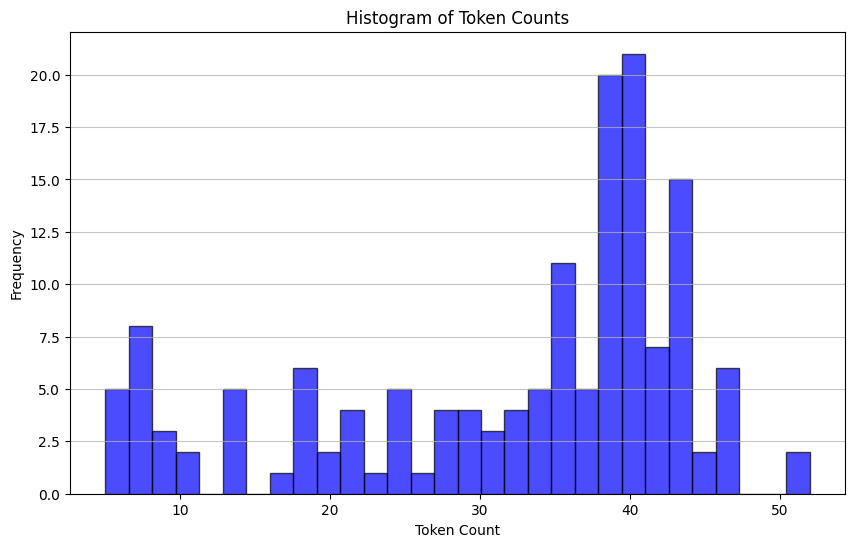

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histogram of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.show

In [14]:
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)
print(
    "Num tokens in all context: %s"
    % num_tokens_from_string(concatenated_content)
)

Num tokens in all context: 5250


In [15]:
from config import set_environment
set_environment()

In [16]:
from langchain_openai import OpenAIEmbeddings, ChatOpenAI

embedding_model = OpenAIEmbeddings()
model = ChatOpenAI(temperature=0, model="gpt-3.5-turbo")

In [17]:
len(texts)

152

In [18]:
global_embeddings = [embedding_model.embed_query(txt) for txt in texts]

In [22]:
len(global_embeddings), len(global_embeddings[0])

(152, 1536)

In [19]:
import matplotlib.pyplot as plt
from typing import Optional
import numpy as np
import umap

def reduce_cluster_embeddings(
                                embeddings: np.ndarray,
                                dim: int,
                                n_neighbors: Optional[int] = None,
                                metric: str = "cosine",
                            ) -> np.ndarray:
    
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


dim = 2
global_embeddings_reduced = reduce_cluster_embeddings(global_embeddings, dim)
global_embeddings_reduced[0]

/home/spadmin/raptor_practice/RAPTOR---Advanced-Retrieval/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


array([11.823359 ,  4.0134683], dtype=float32)

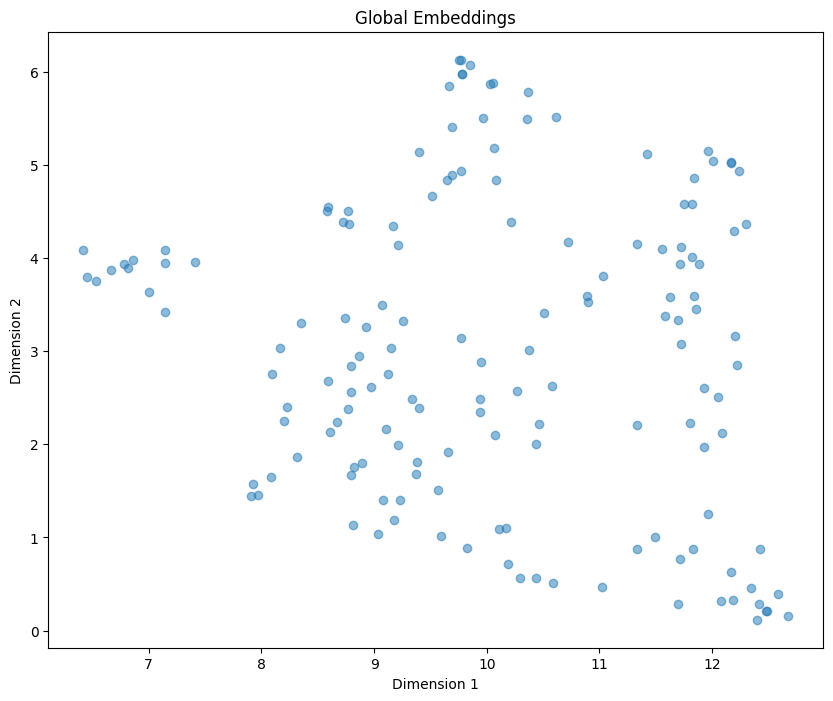

In [20]:
plt.figure(figsize=(10, 8))
plt.scatter(global_embeddings_reduced[:, 0], global_embeddings_reduced[:, 1], alpha=0.5)
plt.title("Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture

def get_optimal_clusters(embeddings: np.ndarray, max_clusters: int = 50, random_state: int = 1234):
    """Find the optimal number of clusters using BIC."""
    max_clusters = min(max_clusters, len(embeddings))
    bics = [GaussianMixture(n_components=n, random_state=random_state).fit(embeddings).bic(embeddings)
            for n in range(1, max_clusters)]
    return np.argmin(bics) + 1

def gmm_clustering(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    """Cluster embeddings using Gaussian Mixture Model."""
    n_clusters = get_optimal_clusters(embeddings)
    print("n_clusters: ", n_clusters)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state).fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters

n_clusters:  6


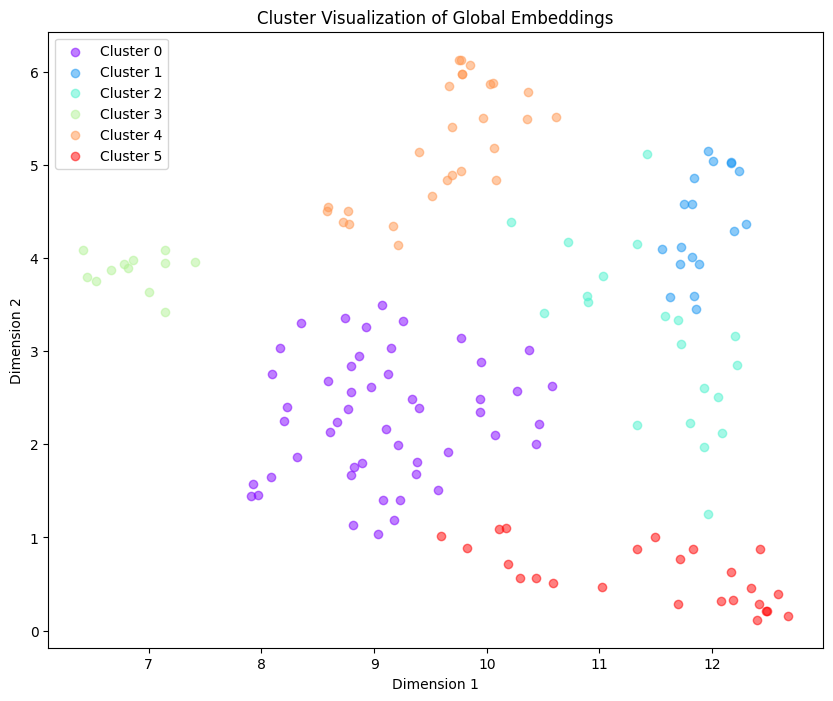

In [24]:
labels, _ = gmm_clustering(global_embeddings_reduced, threshold=0.5)

plot_labels = np.array([label[0] if len(label) > 0 else -1 for label in labels])
plt.figure(figsize=(10, 8))

unique_labels = np.unique(plot_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    mask = plot_labels == label
    plt.scatter(global_embeddings_reduced[mask, 0], global_embeddings_reduced[mask, 1], color=color, label=f'Cluster {label}', alpha=0.5)

plt.title("Cluster Visualization of Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.show()

In [37]:
labels[:5]

[array([1]), array([0]), array([0]), array([0]), array([2])]

In [41]:
labels[0], labels[0][0]

(array([1]), 1)

In [42]:
import pandas as pd

simple_labels = [label[0] if len(label) > 0 else -1 for label in labels]

df = pd.DataFrame({
    'Text': texts,
    'Embedding': list(global_embeddings_reduced),
    'Cluster': simple_labels
})
df.head()

,Text,Embedding,Cluster
0,"Introduction: Welcome to Bella Vista, where ev...","[11.823359, 4.0134683]",1
1,of our culinary philosophy lies a deep reveren...,"[10.2659235, 2.568839]",0
2,art of transforming humble ingredients into ex...,"[10.582658, 2.6216497]",0
3,shores of Sicily to the verdant hills of Tusca...,"[8.672161, 2.2372582]",0
4,Chapter 1: The Essence of Italian Cuisine Ital...,"[10.505753, 3.4118578]",2


In [43]:
def format_cluster_texts(df):
    clustered_texts = {}
    for cluster in df['Cluster'].unique():
        cluster_texts = df[df['Cluster'] == cluster]['Text'].tolist()
        clustered_texts[cluster] = " --- ".join(cluster_texts)
    return clustered_texts

In [44]:
clustered_texts = format_cluster_texts(df)

In [45]:
clustered_texts

{1: "Introduction: Welcome to Bella Vista, where every dish is a love letter to the vibrant flavors, fresh ingredients, and time-honored traditions of Italian cuisine. At the heart of our culinary --- people who create it. At Bella Vista, we embrace this philosophy wholeheartedly, sourcing the finest seasonal ingredients from local farmers, fishermen, and artisans, and allowing their natural --- Chapter 4: From Field to Fork At Bella Vista, we believe that the quality of our ingredients is paramount to the success of our dishes, which is why we go to great lengths to source the freshest, --- elements. At Bella Vista, our chefs draw on a rich palette of ingredients and seasonings to create dishes that are as satisfying as they are memorable. From the zesty tang of citrus and the peppery --- Chapter 8: The Joy of Sharing At Bella Vista, we believe that food has the power to bring people together, to forge connections, and to create lasting memories. Whether you're sharing a leisurely ---

In [46]:
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

template = """You are an assistant to create a detailed summary of the text input prodived.
Text:
{text}
"""
prompt = ChatPromptTemplate.from_template(template)
chain = prompt | model | StrOutputParser()

In [47]:
summaries = {}
for cluster, text in clustered_texts.items():
    summary = chain.invoke({"text": text})
    summaries[cluster] = summary


In [48]:
summaries

{1: "Bella Vista is a restaurant that celebrates the vibrant flavors, fresh ingredients, and time-honored traditions of Italian cuisine. The heart of Bella Vista is the people who create the dishes, sourcing the finest seasonal ingredients from local farmers, fishermen, and artisans. The quality of ingredients is paramount to the success of their dishes, and the chefs at Bella Vista use a rich palette of ingredients and seasonings to create memorable and satisfying dishes.\n\nThe restaurant believes that food has the power to bring people together, forge connections, and create lasting memories. Every meal at Bella Vista is an opportunity to come together, break bread, and revel in the simple pleasures of good food and good company. The menu at Bella Vista is inspired by Sicilian and Venetian cuisine, celebrating the bold, colorful flavors of these regions.\n\nGiovanni, the driving force behind Bella Vista, created the restaurant as a culinary sanctuary where the soulful flavors of Ita

In [49]:
embedded_summaries = [embedding_model.embed_query(summary) for summary in summaries.values()]

embedded_summaries_np = np.array(embedded_summaries)

labels, _ = gmm_clustering(embedded_summaries_np, threshold=0.5)

simple_labels = [label[0] if len(label) > 0 else -1 for label in labels]

n_clusters:  1


In [50]:
clustered_summaries = {}
for i, label in enumerate(simple_labels):
    if label not in clustered_summaries:
        clustered_summaries[label] = []
    clustered_summaries[label].append(list(summaries.values())[i])

In [51]:
clustered_summaries

{0: ["Bella Vista is a restaurant that celebrates the vibrant flavors, fresh ingredients, and time-honored traditions of Italian cuisine. The heart of Bella Vista is the people who create the dishes, sourcing the finest seasonal ingredients from local farmers, fishermen, and artisans. The quality of ingredients is paramount to the success of their dishes, and the chefs at Bella Vista use a rich palette of ingredients and seasonings to create memorable and satisfying dishes.\n\nThe restaurant believes that food has the power to bring people together, forge connections, and create lasting memories. Every meal at Bella Vista is an opportunity to come together, break bread, and revel in the simple pleasures of good food and good company. The menu at Bella Vista is inspired by Sicilian and Venetian cuisine, celebrating the bold, colorful flavors of these regions.\n\nGiovanni, the driving force behind Bella Vista, created the restaurant as a culinary sanctuary where the soulful flavors of It

In [52]:
final_summaries = {}
for cluster, texts in clustered_summaries.items():
    combined_text = ' '.join(texts)
    summary = chain.invoke({"text": combined_text})
    final_summaries[cluster] = summary

In [53]:
final_summaries

{0: "The text provides a detailed overview of Bella Vista, a restaurant that celebrates the vibrant flavors, fresh ingredients, and time-honored traditions of Italian cuisine. The heart of Bella Vista lies in the people who create the dishes, sourcing the finest seasonal ingredients from local farmers, fishermen, and artisans. The chefs at Bella Vista use a rich palette of ingredients and seasonings to create memorable and satisfying dishes. The restaurant believes that food has the power to bring people together, forge connections, and create lasting memories. The menu is inspired by Sicilian and Venetian cuisine, celebrating the bold, colorful flavors of these regions.\n\nGiovanni, the driving force behind Bella Vista, created the restaurant as a culinary sanctuary where the soulful flavors of Italy could be experienced in all their glory. Hospitality is more than just a job at Bella Vista—it's a way of life that permeates every aspect of the dining experience. Giovanni is deeply com

In [54]:
texts_from_df = df['Text'].tolist()
texts_from_clustered_texts = list(clustered_texts.values())
texts_from_final_summaries = list(final_summaries.values())

combined_texts = texts_from_df + texts_from_clustered_texts + texts_from_final_summaries

In [55]:
from langchain_community.vectorstores import Chroma

# Now, use all_texts to build the vectorstore with Chroma
vectorstore = Chroma.from_texts(texts=combined_texts, embedding=embedding_model)


In [56]:
def adjust_final_number(string: str, max_threshold: int, initial_number: int) -> int:
    final_number = initial_number
    while final_number < max_threshold:
        retriever = vectorstore.as_retriever(search_kwargs={"k": final_number})
        docs = retriever.get_relevant_documents(string)
        text = "".join([doc.page_content for doc in docs])
        if num_tokens_from_string(text) < max_threshold:
            final_number += 1
        else:
            break
    return final_number

final_number = adjust_final_number("Who is the owner of the restaurant", 10000, 4)


In [57]:
final_number

155

In [58]:
retriever = vectorstore.as_retriever(search_kwargs={"k": final_number})

In [59]:
from langchain_core.runnables import RunnablePassthrough

template = """
Answer the question based only on the following context:
{context}

Answer the following question:
Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

In [60]:
# Question
rag_chain.invoke("Who is the owner of the restaurant")

'Giovanni Di Napoli is the owner of the restaurant Bella Vista.'